In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import random
import scipy
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils

### Load Car Train Dataset

In [2]:
carstrain_folder = "data/cars_train/"
car_annotations_path = "data/devkit/cars_train_annos.mat"
car_metadata_path = "data/devkit/cars_meta.mat"

#Loading the Dataset

annotations = loadmat(car_annotations_path)
meta = loadmat(car_metadata_path)
meta = np.concatenate(meta["class_names"][0])

dataset = []
columns = ["x1", "y1", "x2", "y2", "class ID", "Model","Image name"]
for example in annotations["annotations"][0]:
    
    filename = example[-1][0]
    annos = np.concatenate(list(example)[:-1]).ravel().tolist()
    carmodel = meta[example[-2][0] - 1][0]
    dataset.append(annos + [carmodel] + [filename])
    
dataset = pd.DataFrame(dataset, columns=columns)

In [3]:
dataset.head()

,x1,y1,x2,y2,class ID,Model,Image name
0,39,116,569,375,14,Audi TTS Coupe 2012,00001.jpg
1,36,116,868,587,3,Acura TL Sedan 2012,00002.jpg
2,85,109,601,381,91,Dodge Dakota Club Cab 2007,00003.jpg
3,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,00004.jpg
4,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,00005.jpg


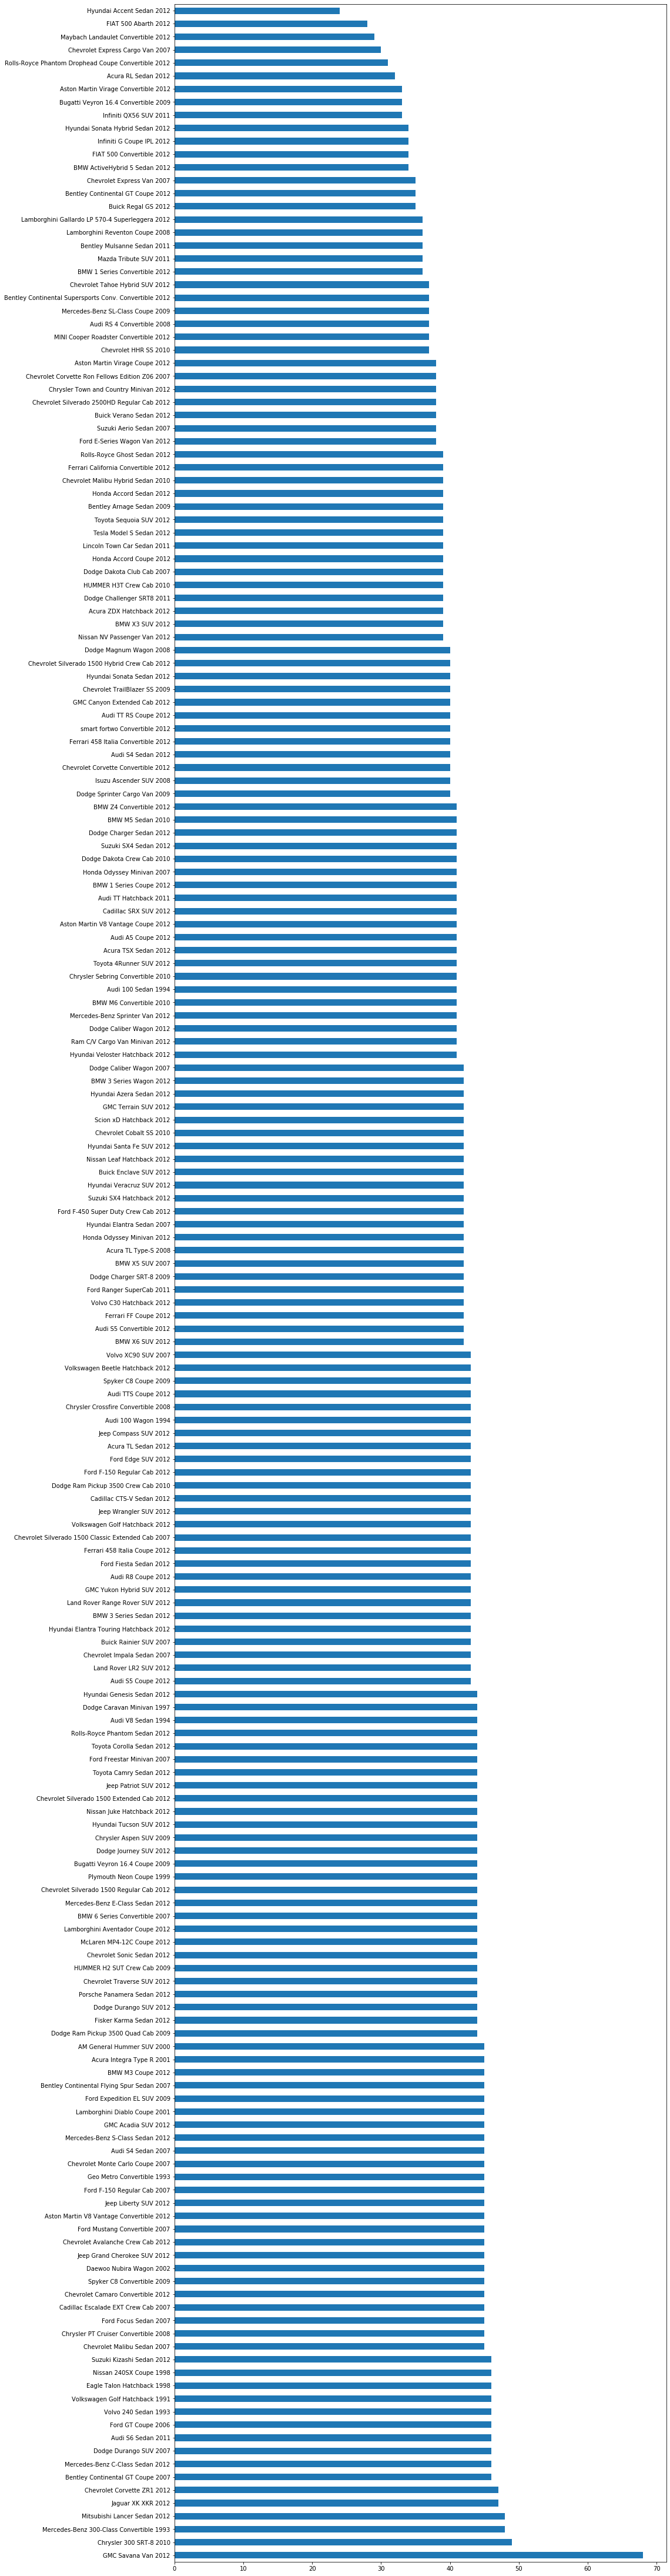

In [5]:
#CHECK DATASET CLASSES
dataset["Model"].value_counts().plot.barh(figsize=(15,80))

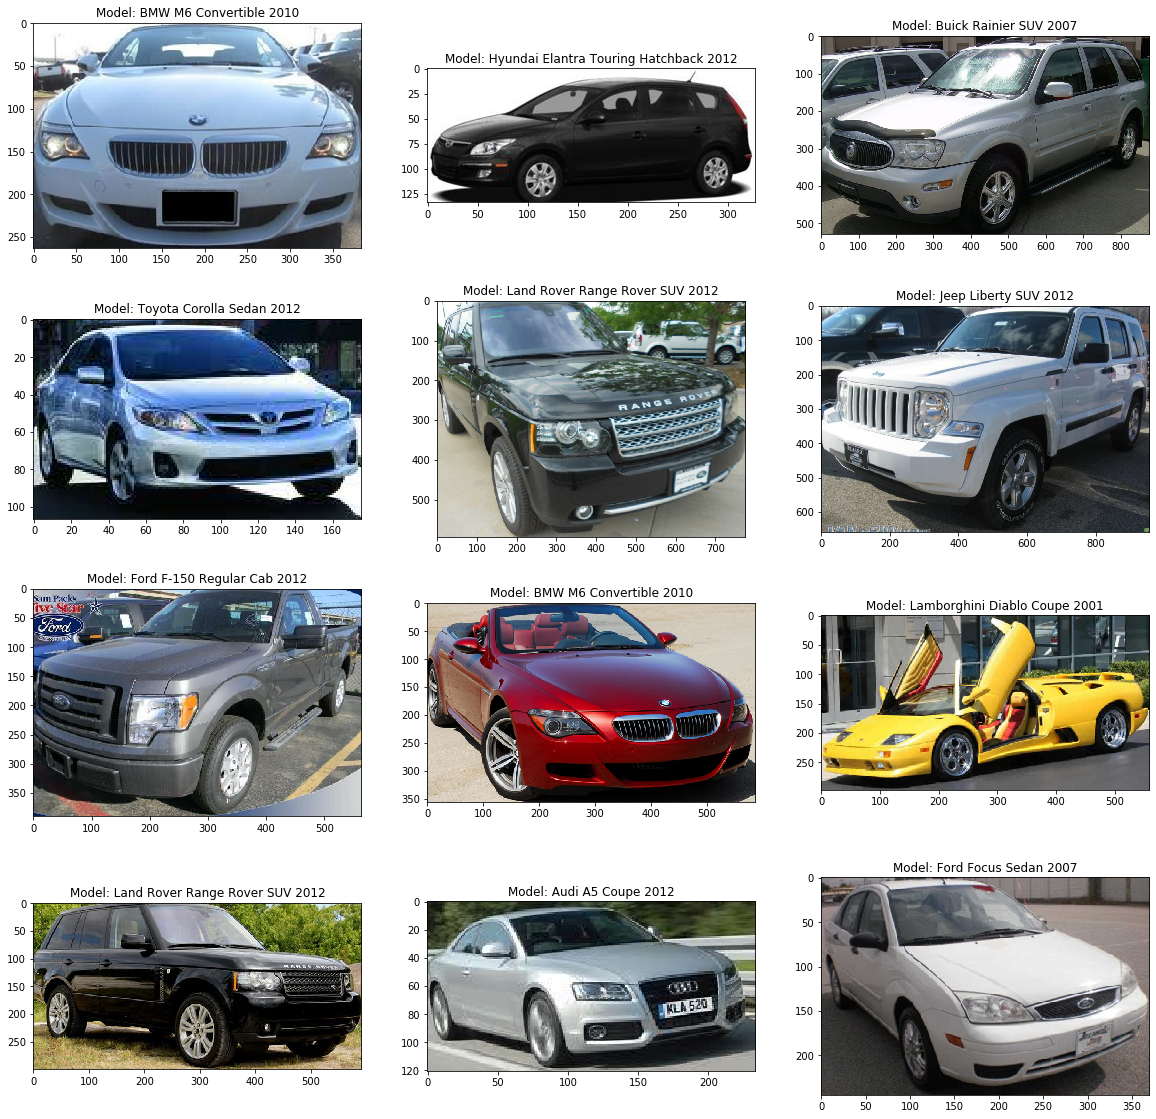

In [5]:
#Quick Sanity Check
fig = plt.figure(figsize=(20,20))
for i in range(1,13):
    plt.subplot(4,3,i)
    
    idx = random.randint(0, annotations["annotations"].shape[1]-1)
    
    image = mpimg.imread(os.path.join(carstrain_folder, dataset.iloc[idx]["Image name"]))
    plt.imshow(image[dataset.iloc[idx]["y1"]: dataset.iloc[idx]["y2"], dataset.iloc[idx]["x1"] : dataset.iloc[idx]["x2"]])
    plt.title("Model: {}".format(dataset.iloc[idx]["Model"]))

plt.show()

In [4]:
import utils
root_dir = "data/cars_train/"
car_annotations_path = "data/devkit/cars_train_annos.mat"
car_metadata_path = "data/devkit/cars_meta.mat"

#Load Meta Data
meta_data = loadmat(car_metadata_path)
meta_data = np.concatenate(meta_data["class_names"][0])

nb_classes = len(meta_data)

dataset = utils.Load_Images(root_dir=root_dir, annotations_path=car_annotations_path, seed=10, test_split=0.2)

[14, 3, 91, 134, 106, 123, 89, 96, 167, 58, 49, 186, 135, 85, 193, 172, 14, 73, 192, 57, 79, 36, 120, 170, 194, 134, 184, 86, 180, 194, 154, 139, 66, 133, 154, 104, 38, 97, 105, 142, 13, 191, 119, 38, 186, 25, 194, 177, 173, 42, 91, 148, 15, 97, 42, 53, 44, 65, 90, 124, 114, 190, 101, 187, 8, 17, 111, 122, 5, 29, 126, 94, 106, 106, 188, 59, 110, 43, 133, 111, 8, 192, 18, 116, 49, 145, 49, 170, 20, 114, 165, 138, 175, 112, 122, 104, 57, 51, 37, 71, 193, 105, 61, 74, 133, 162, 131, 88, 121, 180, 180, 137, 133, 71, 83, 110, 42, 177, 147, 161, 109, 28, 144, 53, 29, 66, 79, 13, 136, 143, 171, 89, 135, 161, 58, 122, 178, 56, 184, 191, 40, 60, 155, 71, 140, 42, 76, 187, 86, 8, 5, 47, 30, 18, 149, 174, 138, 179, 24, 42, 73, 176, 1, 37, 36, 108, 41, 40, 119, 119, 19, 163, 120, 54, 116, 66, 50, 122, 155, 142, 68, 170, 161, 161, 133, 125, 160, 93, 183, 45, 143, 189, 48, 176, 77, 190, 110, 6, 191, 16, 12, 90, 188, 128, 23, 11, 93, 8, 63, 173, 176, 72, 195, 114, 72, 119, 18, 77, 18, 107, 10, 196, 9

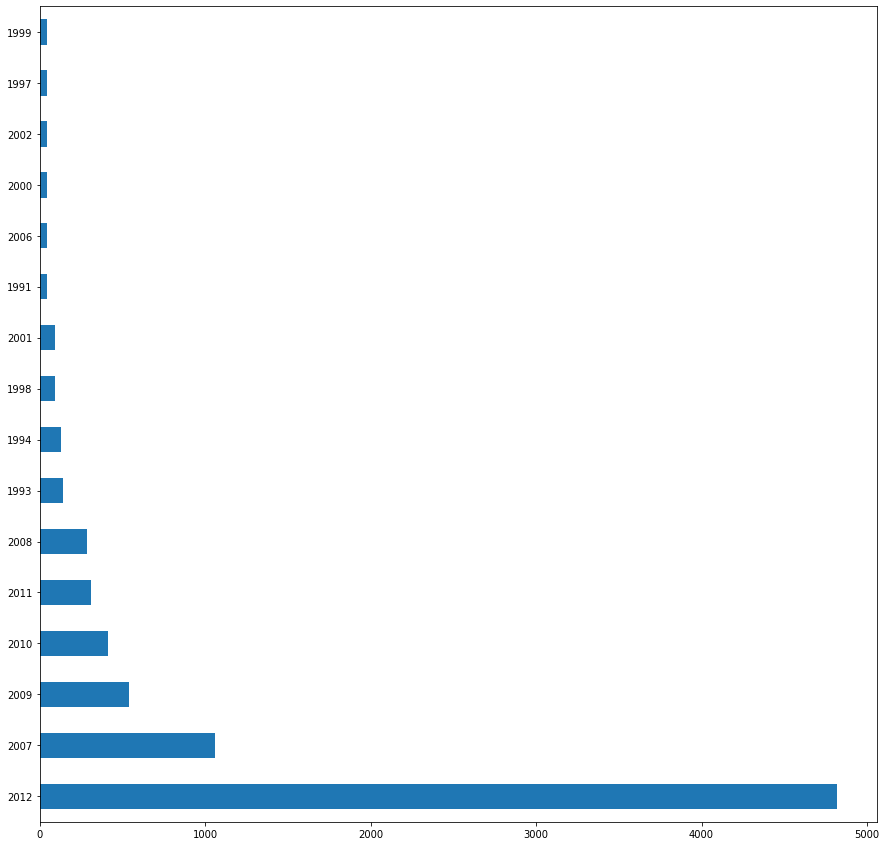

In [9]:
#Check Year Distribution of CARS
years, yearsID = utils.get_Year(dataset["Model"].values)
pd.Series(years).value_counts().plot.barh(figsize=(15,15))

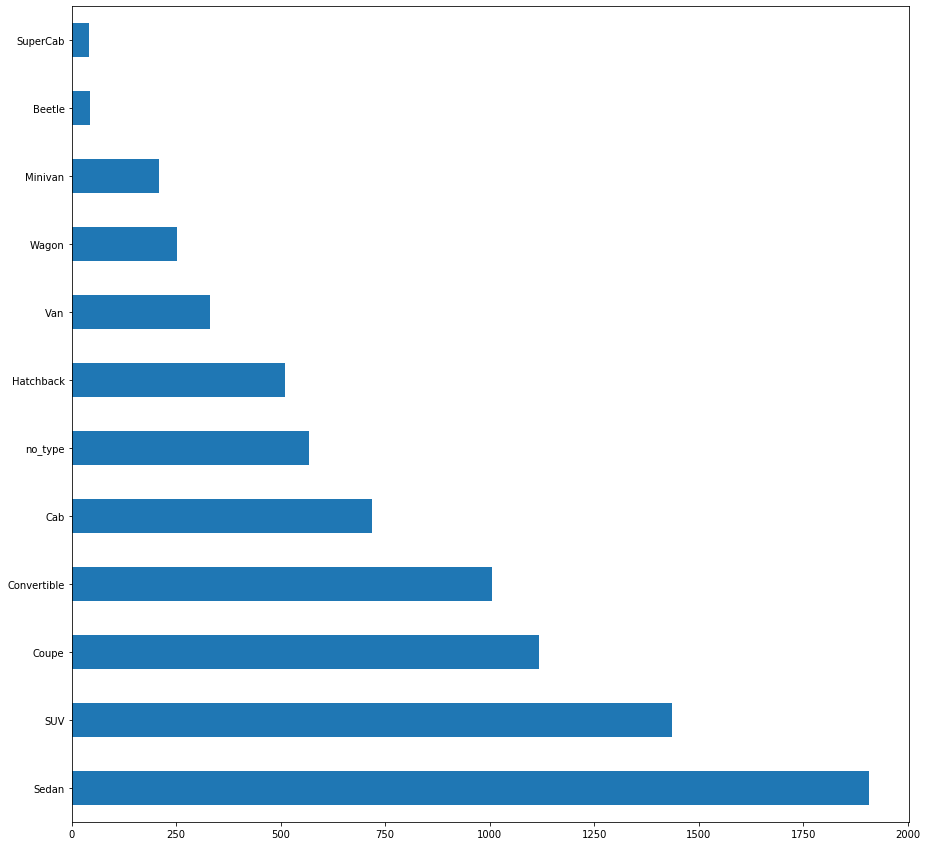

In [10]:
#Check Year Distribution of CARS
years, yearsID = utils.get_Type(dataset["Model"].values)
pd.Series(years).value_counts().plot.barh(figsize=(15,15))

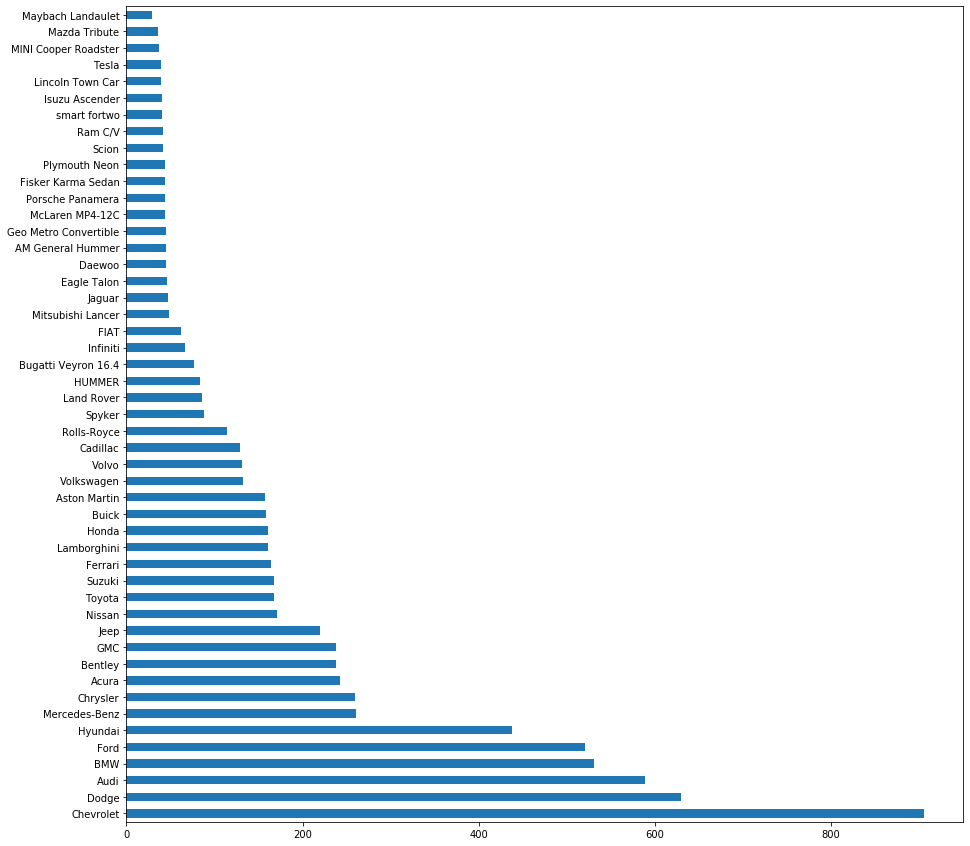

In [11]:
#Check Year Distribution of CARS
years, yearsID = utils.get_Maker(dataset["Model"].values)
pd.Series(years).value_counts().plot.barh(figsize=(15,15))

In [15]:
#Image Normalization
from PIL import Image
mean = []
var = []
for idx, file_name in enumerate(dataset["Image name"]):
    img_path = os.path.join(carstrain_folder, file_name)
    img = Image.open(img_path)
    img = np.asarray(img.convert("RGB"))
    
    Rchan = img[:,:,0]  # Red color channel
    Gchan = img[:,:,1]  # Green color channel
    Bchan = img[:,:,2]  # Blue color channel

    Rchan_mean = Rchan.mean()
    Gchan_mean = Gchan.mean()
    Bchan_mean = Bchan.mean()
    
    Rchan_var = Rchan.var()
    Gchan_var = Gchan.var()
    Bchan_var = Bchan.var()
    
    mean.append([Rchan_mean, Gchan_mean, Bchan_mean])
    var.append([Rchan_var, Gchan_var, Bchan_var])

In [ ]:
#Feature Selection 
#Calculating Cosine Similarity
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

pic_one = str(input("Input first image name\n"))
pic_two = str(input("Input second image name\n"))

# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    
    img = Image.open(image_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [ ]:
X = []
y = dataset["type ID"].values

for idx, val in enumerate(dataset[["type ID", "Image name"]].values):
    img = mpimg.imread(os.path.join(carstrain_folder, val[1]))
    flatten_img = list(cv2.resize(img[dataset.iloc[idx]["y1"]: dataset.iloc[idx]["y2"], dataset.iloc[idx]["x1"] : dataset.iloc[idx]["x2"]], (224,224)).flatten()/255)
    X.append(flatten_img)
    if idx % 1000 == 0:
        print("{} images done".format(idx))

In [ ]:
df=pd.DataFrame(X)
df["Y"] = y

In [ ]:
import time

In [ ]:
#Visualize the Different 
# For reproducability of the results
np.random.seed(42)
N =2000
rndperm = np.random.permutation(df.shape[0])

df_subset = df.loc[rndperm[:N],:].copy()
df_subset.dropna(inplace=True)
data_subset = df_subset.drop(columns=["Y"]).values


tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(data_subset)